In [2]:
import gzip
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
yjmob1 = 'yjmob100k-dataset1.csv.gz' # normal
yjmob1_df = pd.read_csv(yjmob1, compression='gzip')

# yjmob2 = 'yjmob100k-dataset2.csv.gz' # normal + disaster
# yjmob2_df = pd.read_csv(yjmob2, compression='gzip')

In [4]:
def spatial_token(x, y):
    return (x-1)+(y-1)*200

yjmob1_df['combined_xy'] = yjmob1_df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1)

# K-Means (with Elbow Method)

In [5]:
yjmob1_df.head(5) # display

,uid,d,t,x,y,combined_xy
0,0,0,1,79,86,17078
1,0,0,2,79,86,17078
2,0,0,8,77,86,17076
3,0,0,9,77,86,17076
4,0,0,19,81,89,17680


Aggregate only the first 100 step for each user for simplicity

In [6]:
yjmob1_df_chunked = [group[['uid', 't', 'combined_xy']].head(100) for _, group in yjmob1_df.groupby(by='uid')]

In [7]:
# load (loc, time) tuple data into a matrix
yjmob1_loctime = {}
for group in yjmob1_df_chunked:
    yjmob1_loctime_temp = group.apply(lambda row: (row['combined_xy'], row['t']), axis=1).tolist()
    yjmob1_loctime[group['uid'].iloc[0]]= yjmob1_loctime_temp

Select points to perform K-Means Clustering

In [10]:
# Select only location and time data points from 11AM or around 11AM
def select_data_point(data, target_time=22):  # time_range=(20, 25)
    # filtered_data = [(loc, time) for loc, time in data if time_range[0] <= time <= time_range[1]]
    # for loc, time in filtered_data:
    for loc, time in data:
        if time == target_time:
            return loc, time
    # if filtered_data:
        # closest_point = min(filtered_data, key=lambda x: abs(x[1] - target_time))
        # return closest_point
    # return None

# Transform the data to include only the selected data point
transformed_data = []
user_ids = []
for user_id, user_data in yjmob1_loctime.items():
    selected_point = select_data_point(user_data)
    if selected_point:
        transformed_data.append(selected_point)
        user_ids.append(user_id)

# Extract location and time for clustering, transformer type
transformed_data = np.array([[loc, time] for loc, time in transformed_data], dtype=float)
print(len(transformed_data))

95446


In [11]:
from scipy.cluster.vq import kmeans, vq

In [12]:
# Did several k-means clustering

inertia = []
for k in range(1, 11):
    centroids, distortion = kmeans(transformed_data, k)
    inertia.append(distortion)

Select 4 as the number of Clusters in the Whole Population

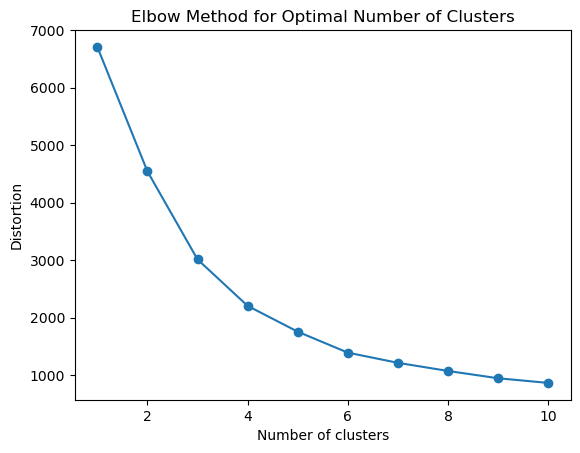

In [13]:
# Elbow method graph

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [14]:
# Do K-means with the best k
centroids, distortion = kmeans(transformed_data, 4)

# Assign each user to the nearest cluster
cluster_assignments, _ = vq(transformed_data, centroids)

# Store clustering result
user_cluster_df = pd.DataFrame({'uid': user_ids, 'cluster': cluster_assignments})

In [15]:
print(len(user_cluster_df[user_cluster_df['cluster']==0]),
      len(user_cluster_df[user_cluster_df['cluster']==1]),
      len(user_cluster_df[user_cluster_df['cluster']==2]),
      len(user_cluster_df[user_cluster_df['cluster']==3]))

26361 39698 20826 8561


Create a custom test and train dataset with randomly selected users from the data

With the whole `selected_users` I can do the horizontal train-test split

In [108]:
selected_users = []
for i in range(4):
    selected_users.append(user_cluster_df[user_cluster_df['cluster'] == i]['uid'].sample(n=250, random_state=123).tolist())

In [109]:
selected_uids = np.array(selected_users).flatten() # 100 users 
selected_uids

array([23571, 74204, 63696, 55441, 96426, 60824, 94235, 51631, 86909,
       42530, 48861, 84743, 35613, 69585, 75261, 23650, 79336, 94821,
       12931, 53463, 18040, 31206, 63322,  9171, 95444, 12150,  7366,
        3674, 16823, 10621, 63463, 17992, 57551, 80754, 99312, 94594,
       36907, 38247,  3951, 66781,  4785, 68770, 98780, 36850, 23834,
       47091, 92289, 37022, 88734, 52290, 98371, 30565,  2799, 92971,
       29639, 54873, 28204, 65041,  4148, 12363, 88515, 30343, 48408,
       94064, 49770,  4355, 98324, 70191, 24881, 51973, 36970,  2723,
       55443, 91833, 66652, 11398, 84277, 94400, 58734, 97420, 30074,
       53544, 58032, 81236, 92600, 70090, 22397, 13197, 73188, 76449,
       17326, 63919, 53835, 61898, 42864, 80041, 33526, 40935, 84723,
       52492, 25654,  6322, 96212,  1410, 53976, 13453, 76253, 21478,
       46157, 22565, 35585, 39060, 18637, 68772, 80634, 47406, 72532,
       63800, 85188, 71122, 37843, 38934, 71111, 42411, 36799, 20926,
       50518, 81605,

In [110]:
# Exported train-test split (horizontal)

selected_uids_df = yjmob1_df[yjmob1_df['uid'].isin(selected_uids)]
train_data = [group.head(100).iloc[:80] for _,group in selected_uids_df.groupby('uid')] # Train
test_data = [group.head(100).iloc[80:101] for _,group in selected_uids_df.groupby('uid')] # Test 

train_df = pd.concat(train_data)
test_df = pd.concat(test_data)
train_df.to_csv('df_train_1k.csv', index=False)
test_df.to_csv('df_test_1k.csv', index=False)

In [113]:
# Exported train-test split (vertical)

all_data = [group.head(100) for _,group in selected_uids_df.groupby('uid')] 
all_df = pd.concat(all_data)
all_df.to_csv('df_all_1k.csv', index=False)

# Random Forest (POI Feature Importance / Selection)

In [32]:
poi_description = pd.read_csv('POI_datacategories.csv', header=None) # Description
# poi_description.index = [(int(i)+1) for i in range(len(poi_description[0]))] # set index
# poi_description = poi_description.rename(columns={0:'Description'}) # set column title

poi_df = pd.read_csv('cell_POIcat.csv.gz', compression='gzip') # read POI data
poi_df['combined_xy'] = poi_df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1) # calculated location

# poi_df = pd.merge(poi, poi_description, left_on='POIcategory', right_index=True) # merge with description

In [33]:
poi_df.head(5)

,x,y,POIcategory,POI_count,combined_xy
0,1,1,48,4,0
1,1,1,58,1,0
2,1,1,59,1,0
3,1,1,69,2,0
4,1,1,73,1,0


### 1. Visit Frequency and POI Type/POI Count (Significant)

In [128]:
loc_frequency = yjmob1_df['combined_xy'].value_counts()

Start simple: Classify if POI: 40, 4, 21, 66, 81 are impacting the frequency significantly

Opinion: T-test is robust enough with the amount of data present (even with making too many assumptions)

In [202]:
# Find location-id and POI count
find_poi = poi_df[(poi_df['combined_xy'].isin(yjmob1_df['combined_xy'].unique())) & (poi_df['POIcategory'] == 40)]

# Find combined_xy with POI existed
combined_xy_with_poi = find_poi['combined_xy'].to_numpy()

# Initialize data for significance test
data = {}
data['combined_xy'] = []
data['visit_frequency'] = []
data['POI_count'] = []

for uid in loc_frequency.index:
    if uid in combined_xy_with_poi:
        data['combined_xy'].append(uid)
        data['visit_frequency'].append(loc_frequency[uid])
        data['POI_count'].append(find_poi[find_poi['combined_xy']==uid]['POI_count'].item())
    else:
        data['combined_xy'].append(uid)
        data['visit_frequency'].append(loc_frequency[uid])
        data['POI_count'].append(0)
        
data = pd.DataFrame(data)

In [208]:
# Group locatiaon-id with POI count <= threshold
data_with_small_poicount = data[data['POI_count'] == 0]['visit_frequency']

# Group location-id with POI count > threshold
data_without_large_poicount = data[data['POI_count'] > 0]['visit_frequency']

In [215]:
# U-Test
u_statistic, p_value = stats.mannwhitneyu(data_with_small_poicount, data_without_large_poicount, alternative='two-sided')
print('P-value:', p_value) # 0.0

# T-test
t_statistic, p_value = stats.ttest_ind(data_with_small_poicount, data_without_large_poicount, equal_var=False)
print('P-value:', p_value) # P-value: 7.30525e-319

P-value: 7.30525e-319


**the presence of the grocery POI impacts visit frequencies.**

*Most frequently visited location data below, these are just dummy codes I don't really want to delete*

In [37]:
poi_df[poi_df['combined_xy']==loc_frequency.index[0]].sort_values(by='POI_count', ascending=False)

,x,y,POIcategory,POI_count,combined_xy
126077,135,77,40,281,15334
126046,135,77,4,134,15334
126062,135,77,21,124,15334
126097,135,77,66,95,15334
126110,135,77,81,73,15334
...,...,...,...,...,...
126098,135,77,67,1,15334
126095,135,77,63,1,15334
126045,135,77,3,1,15334
126065,135,77,25,1,15334


In [40]:
poi_description.iloc[40] # Grocery Store count is high in most frequently visited area

0    Grocery Store
Name: 40, dtype: object

In [78]:
# Get Grocery frequency count
grocery_freq = []
for combined_xy in loc_frequency.index:
    groc = poi_df.loc[(poi_df['POIcategory'] == 40) & (poi_df['combined_xy'] == combined_xy)]['POI_count']
    if (len(groc) > 0):
        grocery_freq.append(groc.iloc[0])
    else:
        grocery_freq.append(0)

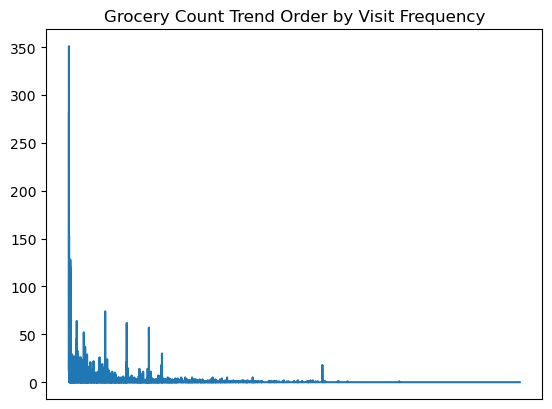

In [81]:
plt.plot(grocery_freq)
plt.title('Grocery Count Trend Order by Visit Frequency')
plt.gca().xaxis.set_visible(False)
plt.show()

### 2. Frequency and POI Density? (Significant Testing)

In [85]:
poi_density = []
for combined_xy in loc_frequency.index:
    poi_density.append(poi_df.loc[poi_df['combined_xy'] == combined_xy].sum())

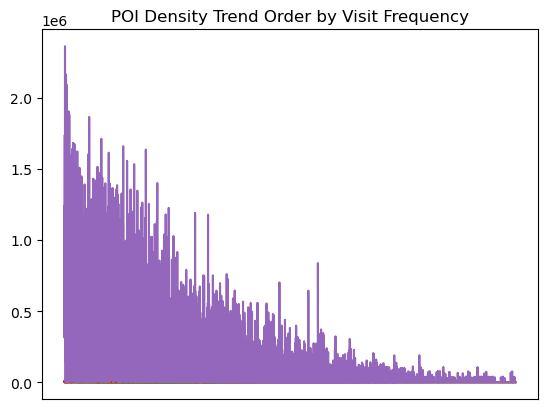

In [86]:
plt.plot(poi_density)
plt.title('POI Density Trend Order by Visit Frequency')
plt.gca().xaxis.set_visible(False)
plt.show()

### 3. Time and POI Type (Significant)

### 4. Certain types of POIs are associated with specific visit patterns (i.e., should there exist a group of people going to the market in the evening)?